# Facial keypoint detection

## Data preparation

In [1]:
!mkdir ./data
!wget -P ./data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n ./data/train-test-data.zip -d ./data
!rm ./data/train-test-data.zip

Streaming output truncated to the last 5000 lines.
  inflating: ./data/test/Elmar_Brok_21.jpg  
  inflating: ./data/test/Elmar_Brok_30.jpg  
  inflating: ./data/test/Elmar_Brok_31.jpg  
  inflating: ./data/test/Elsa_Zylberstein_00.jpg  
  inflating: ./data/test/Elsa_Zylberstein_01.jpg  
  inflating: ./data/test/Elsa_Zylberstein_10.jpg  
  inflating: ./data/test/Elsa_Zylberstein_11.jpg  
  inflating: ./data/test/Elsa_Zylberstein_40.jpg  
  inflating: ./data/test/Elsa_Zylberstein_41.jpg  
  inflating: ./data/test/Elton_John_10.jpg  
  inflating: ./data/test/Elton_John_11.jpg  
  inflating: ./data/test/Elton_John_20.jpg  
  inflating: ./data/test/Elton_John_21.jpg  
  inflating: ./data/test/Elton_John_30.jpg  
  inflating: ./data/test/Elton_John_31.jpg  
  inflating: ./data/test/Elton_John_40.jpg  
  inflating: ./data/test/Elton_John_41.jpg  
  inflating: ./data/test/Emile_Lahoud_00.jpg  
  inflating: ./data/test/Emile_Lahoud_01.jpg  
  inflating: ./data/test/Emile_Lahoud_30.jpg  
  infla

In [2]:
ls ./data/

test/  test_frames_keypoints.csv  training/  training_frames_keypoints.csv


Для совместимости с классом KeypointDataset

In [3]:
!mv ./data/test_frames_keypoints.csv ./data/test/
!mv ./data/training_frames_keypoints.csv ./data/training/

### Data inspection

In [5]:
import os
from torchvision.datasets.folder import IMG_EXTENSIONS

def find_images(path):
    with os.scandir(path) as it:
        files = []
        for entry in it:
            fname, ext = os.path.splitext(entry.name)

            if ext in IMG_EXTENSIONS:
                files.append(os.path.join(path, entry.name))

    return files

train_files = find_images('./data/training')
test_files = find_images('./data/test')   

print(('Train data: {}, Test data: {}').format(
    len(train_files), len(test_files)))# except csv

Train data: 3462, Test data: 2308


In [6]:
import pandas as pd

train_keypoints = pd.read_csv('./data/training/training_frames_keypoints.csv')
test_keypoints = pd.read_csv('./data/test/test_frames_keypoints.csv')

In [7]:
train_keypoints.shape

(3462, 137)

In [8]:
train_keypoints.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,125.0,62.0,130.0,66.0,134.0,73.0,136.0,81.0,139.0,92.0,134.0,96.0,130.0,98.0,126.0,102.0,120.0,102.0,111.0,104.0,105.0,104.0,99.0,102.0,90.0,51.0,89.0,56.0,87.0,60.0,...,68.0,119.0,73.0,117.0,77.0,115.0,79.0,117.0,81.0,115.0,85.0,117.0,90.0,117.0,87.0,122.0,85.0,124.0,81.0,124.0,77.0,124.0,73.0,121.0,70.0,119.0,77.0,119.0,79.0,119.0,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,119.0,58.0,130.0,64.0,136.0,73.0,141.0,85.0,143.0,96.0,137.0,102.0,131.0,107.0,124.0,109.0,114.0,111.0,105.0,111.0,97.0,111.0,88.0,111.0,78.0,51.0,83.0,56.0,81.0,62.0,...,70.0,122.0,75.0,122.0,81.0,120.0,83.0,120.0,85.0,120.0,90.0,120.0,94.0,120.0,90.0,124.0,87.0,126.0,83.0,126.0,79.0,126.0,75.0,124.0,70.0,122.0,79.0,122.0,83.0,122.0,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,103.0,60.0,111.0,62.0,116.0,67.0,122.0,75.0,127.0,86.0,127.0,96.0,123.0,105.0,121.0,113.0,114.0,118.0,106.0,122.0,100.0,124.0,91.0,128.0,81.0,58.0,56.0,62.0,54.0,67.0,...,67.0,103.0,69.0,101.0,73.0,101.0,75.0,101.0,77.0,101.0,84.0,103.0,88.0,108.0,82.0,110.0,77.0,110.0,75.0,110.0,71.0,110.0,69.0,107.0,67.0,103.0,73.0,103.0,75.0,105.0,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,132.0,61.0,141.0,64.0,148.0,73.0,157.0,85.0,163.0,101.0,163.0,116.0,164.0,128.0,161.0,137.0,155.0,144.0,143.0,150.0,134.0,156.0,121.0,162.0,109.0,70.0,68.0,76.0,65.0,85.0,...,76.0,129.0,82.0,130.0,88.0,127.0,91.0,130.0,98.0,130.0,104.0,133.0,110.0,139.0,101.0,142.0,95.0,145.0,88.0,142.0,82.0,142.0,79.0,139.0,76.0,129.0,85.0,133.0,91.0,133.0,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,130.0,71.0,136.0,75.0,138.0,81.0,141.0,92.0,143.0,105.0,139.0,113.0,135.0,122.0,129.0,126.0,122.0,128.0,112.0,130.0,103.0,130.0,95.0,130.0,86.0,58.0,81.0,60.0,74.0,64.0,...,75.0,121.0,79.0,117.0,84.0,115.0,86.0,115.0,90.0,113.0,96.0,115.0,103.0,118.0,98.0,122.0,92.0,124.0,88.0,124.0,84.0,126.0,79.0,124.0,77.0,121.0,84.0,117.0,88.0,117.0,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


Найдем среднее и ско выборки кейпоинтов для обратимости оценки z-score

In [9]:
coordinates = test_keypoints.drop(columns='Unnamed: 0')

X = coordinates[coordinates.columns[::2]]# all x coordinates
Y = coordinates[coordinates.columns[1::2]]# all y coordinates
mean = X.mean().mean(), Y.mean().mean()
std = X.stack().std(), Y.stack().std()
print(f'Mean: {mean}\nStandard deviation: {std}')

Mean: (98.65106951871658, 110.12295645530946)
Standard deviation: (41.72860410125119, 42.92496672693624)


In [10]:
test_keypoints.shape

(770, 137)

In [11]:
test_keypoints.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135
0,James_Wolfensohn_00.jpg,25.0,44.0,25.0,49.0,25.0,54.0,25.0,59.0,26.0,64.0,27.0,67.0,30.0,71.0,33.0,75.0,39.0,76.0,46.0,76.0,52.0,74.0,56.0,72.0,59.0,67.0,62.0,62.0,63.0,57.0,64.0,52.0,65.0,47.0,27.0,40.0,30.0,39.0,32.0,...,33.0,65.0,36.0,64.0,38.0,64.0,39.0,65.0,41.0,64.0,44.0,65.0,47.0,65.0,44.0,66.0,42.0,68.0,39.0,68.0,37.0,68.0,36.0,66.0,33.0,65.0,38.0,65.0,39.0,65.0,42.0,65.0,46.0,65.0,42.0,65.0,39.0,65.0,38.0,65.0
1,Valerie_Harper_30.jpg,55.0,62.0,52.0,72.0,52.0,83.0,55.0,90.0,55.0,101.0,57.0,108.0,60.0,114.0,65.0,121.0,75.0,127.0,88.0,124.0,98.0,122.0,106.0,117.0,114.0,112.0,122.0,102.0,124.0,94.0,129.0,87.0,129.0,76.0,57.0,52.0,60.0,50.0,65.0,...,65.0,101.0,68.0,101.0,70.0,98.0,75.0,101.0,78.0,101.0,83.0,104.0,88.0,106.0,83.0,109.0,78.0,109.0,73.0,109.0,70.0,109.0,68.0,106.0,65.0,101.0,70.0,104.0,75.0,104.0,78.0,104.0,88.0,106.0,78.0,106.0,75.0,104.0,70.0,104.0
2,Kristen_Breitweiser_11.jpg,60.0,88.0,60.0,98.0,63.0,109.0,65.0,116.0,68.0,127.0,73.0,135.0,78.0,137.0,83.0,140.0,96.0,143.0,109.0,138.0,119.0,135.0,127.0,130.0,132.0,125.0,135.0,115.0,135.0,105.0,137.0,95.0,137.0,84.0,63.0,75.0,65.0,70.0,71.0,...,78.0,119.0,83.0,114.0,89.0,112.0,91.0,112.0,94.0,112.0,101.0,112.0,109.0,117.0,101.0,120.0,96.0,122.0,94.0,122.0,89.0,122.0,83.0,122.0,81.0,119.0,89.0,117.0,91.0,114.0,96.0,114.0,106.0,117.0,96.0,117.0,94.0,117.0,89.0,117.0
3,Elizabeth_Dole_31.jpg,41.0,96.0,43.0,104.0,47.0,113.0,49.0,120.0,56.0,128.0,64.0,135.0,73.0,139.0,83.0,144.0,96.0,144.0,105.0,137.0,107.0,133.0,107.0,127.0,109.0,120.0,109.0,112.0,109.0,103.0,109.0,95.0,107.0,86.0,60.0,83.0,66.0,79.0,73.0,...,83.0,122.0,90.0,120.0,94.0,116.0,98.0,116.0,100.0,116.0,103.0,116.0,103.0,118.0,103.0,122.0,100.0,125.0,98.0,127.0,94.0,127.0,90.0,124.0,83.0,122.0,94.0,120.0,96.0,118.0,98.0,118.0,103.0,118.0,98.0,120.0,96.0,122.0,94.0,122.0
4,Kit_Bond_20.jpg,35.0,67.0,37.0,74.0,41.0,81.0,44.0,87.0,48.0,96.0,51.0,103.0,58.0,108.0,66.0,112.0,76.0,112.0,85.0,107.0,91.0,100.0,94.0,93.0,96.0,84.0,96.0,77.0,96.0,70.0,96.0,64.0,94.0,55.0,42.0,67.0,48.0,65.0,51.0,...,60.0,94.0,64.0,96.0,69.0,94.0,73.0,94.0,74.0,94.0,80.0,94.0,83.0,93.0,80.0,98.0,78.0,101.0,73.0,101.0,69.0,101.0,66.0,99.0,60.0,94.0,69.0,96.0,73.0,96.0,76.0,96.0,83.0,93.0,76.0,98.0,73.0,98.0,69.0,98.0


In [12]:
kpts = train_keypoints[train_keypoints['Unnamed: 0'] == 'Agbani_Darego_52.jpg']
kpts = kpts.drop('Unnamed: 0', axis=1).to_numpy().reshape(68, 2).astype('uint8')
kpts

array([[ 88, 114],
       [ 84, 128],
       [ 80, 147],
       [ 80, 158],
       [ 80, 176],
       [ 84, 191],
       [ 88, 206],
       [ 95, 224],
       [110, 239],
       [132, 236],
       [147, 229],
       [161, 218],
       [176, 204],
       [187, 189],
       [195, 178],
       [202, 167],
       [209, 149],
       [ 99, 110],
       [106, 110],
       [117, 118],
       [125, 122],
       [128, 129],
       [161, 141],
       [172, 141],
       [180, 141],
       [191, 141],
       [198, 145],
       [139, 155],
       [132, 166],
       [128, 181],
       [125, 188],
       [117, 184],
       [117, 192],
       [125, 195],
       [132, 195],
       [136, 192],
       [102, 132],
       [110, 132],
       [117, 136],
       [125, 144],
       [117, 144],
       [106, 136],
       [158, 155],
       [169, 155],
       [176, 156],
       [184, 159],
       [176, 163],
       [165, 159],
       [ 99, 195],
       [106, 199],
       [117, 199],
       [121, 203],
       [128,

Всего 68 точек

In [13]:
import matplotlib.pyplot as plt

def show_keypoints(image, kpts, mean=(0, 0), std=(1, 1)):
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    
    plt.scatter(kpts[:, 0]*std[0] + mean[0],
                kpts[:, 1]*std[1] + mean[1], s=50, marker='.', c='k')

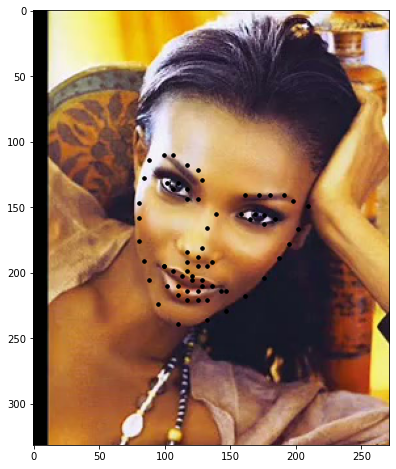

In [14]:
from PIL import Image

img = Image.open('./data/training/Agbani_Darego_52.jpg')
show_keypoints(img, kpts)

In [15]:
# подробная архитектура модели
# гиперпараметры обучения
# алгоритмы оптимизации, критерии, метрики
# трансформации данных
# логи обучения
# использование gpu, модели


# Model development

I have defined a way of loading the dataset and transforming data into preprocessing.py and next I create loaders for training and test data.

In [35]:
from os.path import join
from torchvision.transforms import Compose
from preprocessing import (KeypointDataset, Resized, CenterCropped, ToTensored,
                           Normalized)
from torch.utils.data import DataLoader

tform = {'training': Compose([Resized(256),
                              CenterCropped(224),
                              ToTensored(),
                              Normalized(kpts_mean=mean,
                                         kpts_std=std)
                             ]),
         'test': Compose([Resized(256),
                          CenterCropped(224),
                          ToTensored(),
                          Normalized(kpts_mean=mean,
                                     kpts_std=std)])}

root = './data'
dataset = {x: KeypointDataset(join(root, x), tform[x]) for x in tform.keys()}
loaders = {x: DataLoader(dataset[x],
                         batch_size=64,
                         shuffle=True,
                         num_workers=2,
                         pin_memory=True,
                         drop_last=False) for x in tform.keys()}

I will create a simple convolutional network.

In [36]:
from torch import flatten, cuda
from torch.nn import Conv2d, MaxPool2d, Linear, Dropout, BatchNorm1d, Module
from torch.nn.functional import relu


class KeypointDetector(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(3, 32, 3, stride=2)
        self.conv2 = Conv2d(32, 32, 3, stride=2)
        self.pool1 = MaxPool2d(2, stride=2)

        self.conv3 = Conv2d(32, 32, 3, stride=2)
        self.conv4 = Conv2d(32, 32, 3, stride=2)
        self.pool2 = MaxPool2d(2, stride=2)

        self.fc1 = Linear(288, 2048)
        self.fc2 = Linear(2048, 136)

    def forward(self, x):
        x = relu(self.conv1(x))
        x = relu(self.conv2(x))
        x = self.pool1(x)

        x = relu(self.conv3(x))
        x = relu(self.conv4(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = x.view(x.size(0), -1, 2)
        return x


model = KeypointDetector()
use_cuda = cuda.is_available()
if use_cuda:
    model = model.cuda()

I will add an auxiliary function to determine the timing of training and testing functions.

In [61]:
import time
import functools


def timed(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        t0 = time.time()
        name = func.__name__
        class_name = func.__class__.__name__
        print(f'{class_name} {name} stared at: {time.ctime(t0)}')

        result = func(*args, **kwargs)

        t = time.time() - t0
        print(f'{class_name} {name} ended at: {time.ctime(t + t0)}.\n\
Elapsed time:{t:.5f} sec')

        return result
    return wrapper

I will use stochastic gradient descent for training and mean square error to estimate the adequacy of the model.

In [38]:
from torch.optim import SGD
from torch.nn import MSELoss, L1Loss, SmoothL1Loss


criterion = MSELoss()
optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9)

@timed
def train(model, loaders, criterion, optimizer, epochs):
    model.train()

    for epoch in range(epochs):
        epoch_loss = 0.0
        for ix, (img, kpts) in enumerate(loaders['training']):
            if use_cuda:
                img = img.cuda()
                kpts = kpts.cuda()

            optimizer.zero_grad()

            out = model(img)

            loss = criterion(out, kpts)
            loss.backward()

            optimizer.step()

            epoch_loss += loss.item() * img.size(0)

        epoch_loss /= len(loaders['training'].dataset)
        print(epoch_loss)

# Training & Testing

In [39]:
epochs = 40
train(model, loaders, criterion, optimizer, epochs)

function train stared at: Tue Mar 30 18:19:48 2021
0.1814972412191947
0.1109063613671295
0.10995472251404785
0.10231752641572214
0.09174665531271596
0.07902043290406138
0.06735939388327486
0.05916498889603207
0.053309516018177995
0.049473552626209547
0.04685199366487532
0.044038504174873365
0.0425638586782018
0.03985423558019855
0.038042093196196204
0.03695343794857471
0.03525578829119276
0.03409131893975276
0.03256230149687128
0.03189040231504997
0.03044117243819537
0.030286118050295793
0.02754780254797533
0.026434812872874504
0.025678073159881163
0.024901644249808782
0.024027159450449812
0.023323813630865185
0.022559686411647767
0.02189787201678078
0.021343836555465116
0.021206643456051902
0.02020826495716866
0.019166524956193292
0.01914263718477964
0.018232368238395105
0.017773779142477967
0.017869468637678076
0.017367429099438992
0.016589342838703107
function train ended at: Tue Mar 30 18:30:51 2021. Elapsed time:663.17987 sec


Test function.

In [70]:
@timed
def test(model, loaders, criterion):
    if use_cuda:
      model = model.cuda()

    model.eval()

    epoch_loss = 0.0
    for img, kpts in loaders['test']:
        if use_cuda:
            img = img.cuda()
            kpts = kpts.cuda()

        loss = criterion(model(img), kpts)

        epoch_loss += loss.item() * img.size(0)

    epoch_loss /= len(loaders['test'].dataset)
    print(epoch_loss)

In [71]:
test(model, loaders, criterion)

function test stared at: Tue Mar 30 18:56:36 2021
0.023582883856513283
function test ended at: Tue Mar 30 18:56:40 2021.
Elapsed time:3.67841 sec


Visual quality check of the regression.

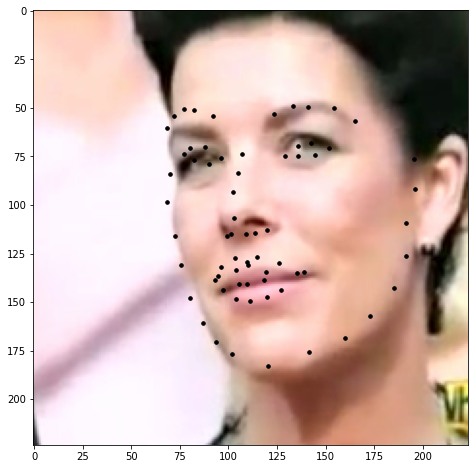

In [46]:
import numpy as np
from PIL import Image


pic, _ = loaders['test'].dataset.__getitem__(19)
model.eval()
pic = pic.cpu()
model = model.cpu()
pred = model(pic.cpu().unsqueeze(0))

pic_mean = (0.485, 0.456, 0.406)
pic_std = (0.229, 0.224, 0.225)

def to_denorm_img(pic, mean, std):
    pic = np.transpose(pic, (1, 2, 0)).numpy() * std + mean
    pic = (pic * 255).astype('uint8')
    pic = Image.fromarray(pic)

    return pic


pic = to_denorm_img(pic, pic_mean, pic_std)
pred = pred.squeeze(0).view(68, 2).detach().numpy()

show_keypoints(pic, pred, mean=mean, std=std)